### 課題<br>
・Kaggle:PlayGroundより『アワビの年齢当て』<br>
・期間2024.4.1-4.30

---

### ライブラリ

In [686]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image

---

### データの確認

In [687]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [688]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


<u>カラム名、アワビの生態</u><br>
**Sex**:性別<br>
アワビの肝が肥大化する夏・秋に限り性別が分かる。肝（生殖腺）から、白色がオス、緑色がメスとなる。<br>
  M:male オス　F:Female メス　I:Infant 稚貝<br>
**Length**:長さ、**Diameter**:直径はどう違うのか不明。<br>
**Height**:厚み？<br>
**Whole weight**:全体重量。**whole weight1**・**whole weight2**・**Shell weight**:殻重量はその内訳か。<br>
**Rings**:年輪【本日のターゲット】<br>
アワビの年齢形質（年齢が読み取れる部位）は殻の表面にできる輪紋で、1年に1本産卵期にできると言われている。<br>
アワビの寿命は15~20年と言われている。長い個体だと30年生きることもある。

In [689]:
#データ数、欠損値、Dtypeの確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


90615行、10列のデータ数。<br>
欠損値なしのため欠損値処理なし。<br>
Sexがobject型以外はint型、float型。

In [690]:
#ワンホットエンコーディング
'''def transform_df(df):
    df['Sex'] = df['Sex'].map({'I': 0, 'M': 1, 'F': 2}) 
    return df

df_train = transform_df(df_train)
df_test = transform_df(df_test)'''

"def transform_df(df):\n    df['Sex'] = df['Sex'].map({'I': 0, 'M': 1, 'F': 2}) \n    return df\n\ndf_train = transform_df(df_train)\ndf_test = transform_df(df_test)"

In [691]:
#ラベルエンコーディング
def transform_enc_sex(df):
    df_onehot = pd.get_dummies(df.Sex)
    df = pd.concat([df, df_onehot], axis=1)
    df = df.drop('Sex', axis=1)
    return df

df_train = transform_enc_sex(df_train)
df_test = transform_enc_sex(df_test)

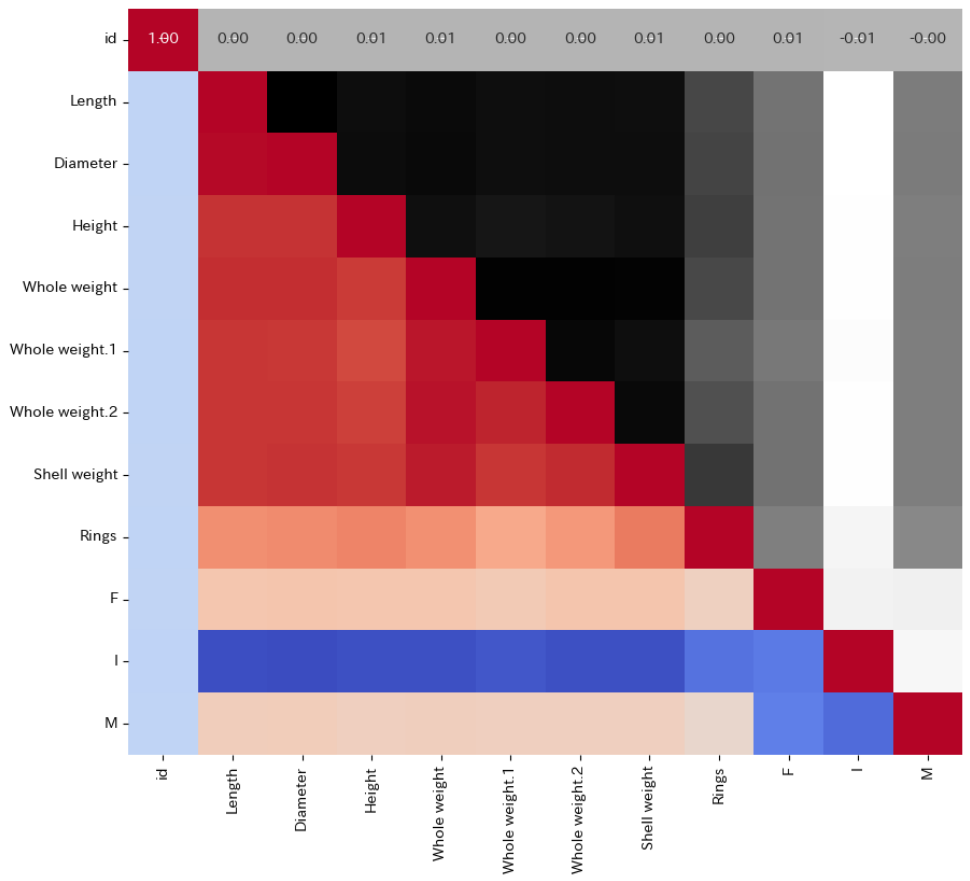

In [692]:
img = Image.open('picture\label_encp.png')
img

Iの相関がすべての要素に対してかなり低く出ている。<br>
ワンホットでやっていく。

In [693]:
df_train.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,F,I,M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,True,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,True,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,False,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,False,True,False


In [694]:
df_test.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,F,I,M
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,False,False,True
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,False,False,True
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,False,False,True
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,False,False,True
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,False,True,False


In [695]:
#正規分布用モジュール
from statistics import mean, median, variance, stdev
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [696]:
df_train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Heightが０はおかしいので除去する。

In [697]:
df_train = df_train.query('Height != 0')
df_train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000
mean,45307.061992,0.517106,0.401686,0.135473,0.789066,0.340790,0.169428,0.225900,9.696918
std,26158.188586,0.118216,0.098025,0.037993,0.457668,0.204428,0.100909,0.130204,3.176278
min,0.000000,0.075000,0.055000,0.004000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22654.000000,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.000000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [698]:
def transform_df_nb(column):
    # 対数変換を適用
    df_train[column] = np.log1p(df_train[column])
    df_test[column] = np.log1p(df_test[column])


In [699]:
transform_df_nb('Length')
transform_df_nb('Diameter')
transform_df_nb('Height')
transform_df_nb('Whole weight')
transform_df_nb('Whole weight.1')
transform_df_nb('Whole weight.2')
transform_df_nb('Shell weight')

In [700]:
df_test.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
count,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000
mean,120820.000000,0.413867,0.335358,0.126732,0.549363,0.282317,0.152864,0.198353
std,17439.297893,0.080365,0.071647,0.033525,0.258142,0.149374,0.085026,0.104575
min,90615.000000,0.072321,0.053541,0.000000,0.001998,0.001000,0.000500,0.001499
25%,105717.500000,0.371564,0.296394,0.104360,0.350305,0.164242,0.082962,0.113329
50%,120820.000000,0.435024,0.354172,0.131028,0.588620,0.284427,0.153579,0.202941
75%,135922.500000,0.470004,0.385262,0.148420,0.727549,0.381514,0.209045,0.266203
max,151025.000000,0.587787,0.500775,0.739554,1.341689,0.911479,0.495610,0.695145


In [701]:

def transform_df_nb(column):
    df_train[column], _ = boxcox(df_train[column])
    df_test[column], _ = boxcox(df_test[column])
#transform_df_nb('')


In [754]:
transform_df_nb('Length')
transform_df_nb('Diameter')
transform_df_nb('Height')
transform_df_nb('Whole weight')
transform_df_nb('Whole weight.1')
transform_df_nb('Whole weight.2')
transform_df_nb('Shell weight')

ValueError: Data must be positive.

boxcox<br>
ValueError: Data must be positive.

In [702]:
'''transform_df_nb('Length')
transform_df_nb('Diameter')
transform_df_nb('Height')
transform_df_nb('Whole weight.1')
transform_df_nb('Whole weight')
transform_df_nb('Whole weight.2')
transform_df_nb('Shell weight')
transform_df_nb('Rings')'''

"transform_df_nb('Length')\ntransform_df_nb('Diameter')\ntransform_df_nb('Height')\ntransform_df_nb('Whole weight.1')\ntransform_df_nb('Whole weight')\ntransform_df_nb('Whole weight.2')\ntransform_df_nb('Shell weight')\ntransform_df_nb('Rings')"

In [703]:
'''from sklearn.preprocessing import PowerTransformer

# PowerTransformerオブジェクトを作成し、Yeo-Johnson変換を実行する
pt = PowerTransformer(method='yeo-johnson')
df_train_nb = pt.fit_transform(df_train)
df_test_nb = pt.fit_transform(df_test)

# NumPy配列から新しいデータフレームを作成する

df_train = pd.DataFrame(df_train_nb, columns=df_train.columns)
df_test = pd.DataFrame(df_test_nb, columns=df_test.columns)'''


"from sklearn.preprocessing import PowerTransformer\n\n# PowerTransformerオブジェクトを作成し、Yeo-Johnson変換を実行する\npt = PowerTransformer(method='yeo-johnson')\ndf_train_nb = pt.fit_transform(df_train)\ndf_test_nb = pt.fit_transform(df_test)\n\n# NumPy配列から新しいデータフレームを作成する\n\ndf_train = pd.DataFrame(df_train_nb, columns=df_train.columns)\ndf_test = pd.DataFrame(df_test_nb, columns=df_test.columns)"

In [704]:
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)'''

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nscaler.fit(X_train)'

In [705]:
'''X_train_scaled = scaler.transform(X_train)
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=df_train.columns)

df_X_train_scaled.head()'''


'X_train_scaled = scaler.transform(X_train)\ndf_X_train_scaled = pd.DataFrame(X_train_scaled, columns=df_train.columns)\n\ndf_X_train_scaled.head()'

In [706]:
df_train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000
mean,45307.061992,0.413621,0.335131,0.126490,0.548729,0.281960,0.152858,0.198138,9.696918
std,26158.188586,0.080807,0.072083,0.033463,0.258492,0.149587,0.085182,0.104857,3.176278
min,0.000000,0.072321,0.053541,0.003992,0.001998,0.001000,0.000500,0.001499,1.000000
25%,22654.000000,0.368109,0.296394,0.104360,0.350305,0.163394,0.082962,0.113329,8.000000
50%,45307.000000,0.435024,0.354172,0.131028,0.587509,0.285179,0.153579,0.202941,9.000000
75%,67960.000000,0.470004,0.385262,0.148420,0.726340,0.380489,0.209045,0.266203,11.000000
max,90614.000000,0.596085,0.500775,0.756122,1.341689,0.911479,0.565314,0.695644,29.000000


---

２つの相互作用特徴量しらみつぶし用関数

In [707]:
#特徴量関数

def kakeawase(df, origin_clumnname1, origin_clumnname2, new_clumnname):
    df[new_clumnname] = df[origin_clumnname1] * df[origin_clumnname2]
    return df

'''kumiawase_name =  'Length', 'Diameter', 'Length*Diameter'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], kumiawase_name[2])
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], kumiawase_name[2])'''

"kumiawase_name =  'Length', 'Diameter', 'Length*Diameter'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], kumiawase_name[2])\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], kumiawase_name[2])"

２つの相互作用特徴量を洗い出す

In [708]:
#1 Length*Diameterを追加
'''kumiawase_name = ('Length', 'Diameter')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Length', 'Diameter')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [709]:
#2 Length*Heightを追加
'''kumiawase_name = ('Length', 'Height')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Length', 'Height')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [710]:
#3 Length*Wholeweightを追加
'''
kumiawase_name = ('Length', 'Height')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)
'''

"\nkumiawase_name = ('Length', 'Height')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)\n"

In [711]:
#4 Length*Whole weight.1を追加
'''
kumiawase_name = ('Length', 'Whole weight.1')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"\nkumiawase_name = ('Length', 'Whole weight.1')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [712]:
#5 Length*Wholeweight.2を追加
'''kumiawase_name = ('Length', 'Whole weight.2')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Length', 'Whole weight.2')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [713]:
#6 Length*Shellweight を追加
'''kumiawase_name = ('Length', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Length', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [714]:
#7 Diameter*Heightを追加
'''kumiawase_name = ('Diameter', 'Height')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Diameter', 'Height')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [715]:
#8 Diameter*Wholeweightを追加
'''kumiawase_name = ('Diameter', 'Whole weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Diameter', 'Whole weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [716]:
#9 Diameter*Wholeweight.1を追加
'''kumiawase_name = ('Diameter', 'Whole weight.1')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Diameter', 'Whole weight.1')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [717]:
#10 Diameter*Wholeweight.2を追加
'''kumiawase_name = ('Diameter', 'Whole weight.2')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Diameter', 'Whole weight.2')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [718]:
#11 Diameter*Shellweightを追加
'''kumiawase_name = ('Diameter', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Diameter', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [719]:
#12 Height*Wholeweightを追加
'''kumiawase_name = ('Height', 'Whole weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Height', 'Whole weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [720]:
#13 Height*Wholewheit.1を追加
'''kumiawase_name = ('Height', 'Whole weight.1')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Height', 'Whole weight.1')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [721]:
#14 Height*Wholewheit.2を追加
'''kumiawase_name = ('Height', 'Whole weight.2')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Height', 'Whole weight.2')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [722]:
#15 Height*Shellwheitを追加
'''
kumiawase_name = ('Height', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)
'''

"\nkumiawase_name = ('Height', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)\n"

In [723]:
#16 Wholeweight*Wholeweight.1を追加
'''kumiawase_name = ('Whole weight', 'Whole weight.1')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight', 'Whole weight.1')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [724]:
#17 Wholeweight*Wholeweight.2を追加
'''kumiawase_name = ('Whole weight', 'Whole weight.2')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight', 'Whole weight.2')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [725]:
#18 Wholeweight*Shell weightを追加
'''kumiawase_name = ('Whole weight', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [726]:
#19 Wholeweight.1*Wholeweight.2を追加
'''kumiawase_name = ('Whole weight.1', 'Whole weight.2')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight.1', 'Whole weight.2')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [727]:
#20 Wholeweight.1*Shellweightを追加
'''kumiawase_name = ('Whole weight.1', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight.1', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [728]:
#21 Wholeweight.2*Shellweightを追加
'''kumiawase_name = ('Whole weight.2', 'Shell weight')
new_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'
df_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)
df_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)'''

"kumiawase_name = ('Whole weight.2', 'Shell weight')\nnew_name = f'{kumiawase_name[0]}*{kumiawase_name[1]}'\ndf_train = kakeawase(df_train, kumiawase_name[0], kumiawase_name[1], new_name)\ndf_test = kakeawase(df_test, kumiawase_name[0], kumiawase_name[1], new_name)"

In [729]:
df_train.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,F,I,M
0,0,0.438255,0.357674,0.139762,0.571827,0.284050,0.136714,0.215111,11,True,False,False
1,1,0.488580,0.398776,0.135405,0.756122,0.377066,0.244122,0.277632,11,True,False,False
2,2,0.148420,0.104360,0.024693,0.020783,0.005485,0.002996,0.004988,6,False,True,False
3,3,0.466874,0.388658,0.139762,0.649456,0.318817,0.186894,0.223144,10,False,False,True
4,4,0.441476,0.354172,0.122218,0.577736,0.314446,0.148420,0.180236,9,False,True,False


In [730]:
df_test.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,F,I,M
0,90615,0.497740,0.388658,0.144100,0.805583,0.481500,0.271934,0.262749,False,False,True
1,90616,0.457425,0.378436,0.148420,0.684611,0.391028,0.198441,0.242946,False,False,True
2,90617,0.444686,0.350657,0.131028,0.609494,0.301955,0.169321,0.215515,False,False,True
3,90618,0.451076,0.398776,0.135405,0.628075,0.301955,0.171008,0.211071,False,False,True
4,90619,0.347130,0.281412,0.104360,0.306013,0.146263,0.064851,0.099845,False,True,False


In [731]:
# 統計情報を取得
df_train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000,90609.000000
mean,45307.061992,0.413621,0.335131,0.126490,0.548729,0.281960,0.152858,0.198138,9.696918
std,26158.188586,0.080807,0.072083,0.033463,0.258492,0.149587,0.085182,0.104857,3.176278
min,0.000000,0.072321,0.053541,0.003992,0.001998,0.001000,0.000500,0.001499,1.000000
25%,22654.000000,0.368109,0.296394,0.104360,0.350305,0.163394,0.082962,0.113329,8.000000
50%,45307.000000,0.435024,0.354172,0.131028,0.587509,0.285179,0.153579,0.202941,9.000000
75%,67960.000000,0.470004,0.385262,0.148420,0.726340,0.380489,0.209045,0.266203,11.000000
max,90614.000000,0.596085,0.500775,0.756122,1.341689,0.911479,0.565314,0.695644,29.000000


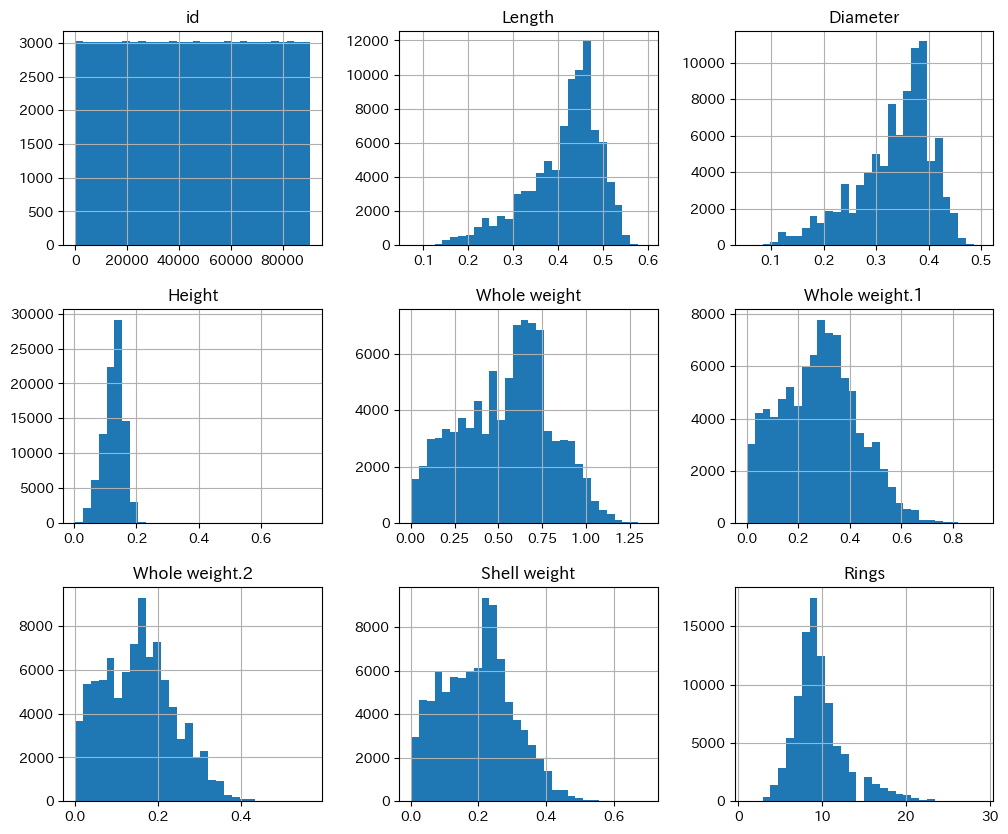

In [732]:
df_train.hist(bins=30, figsize=(12, 10))
plt.show()

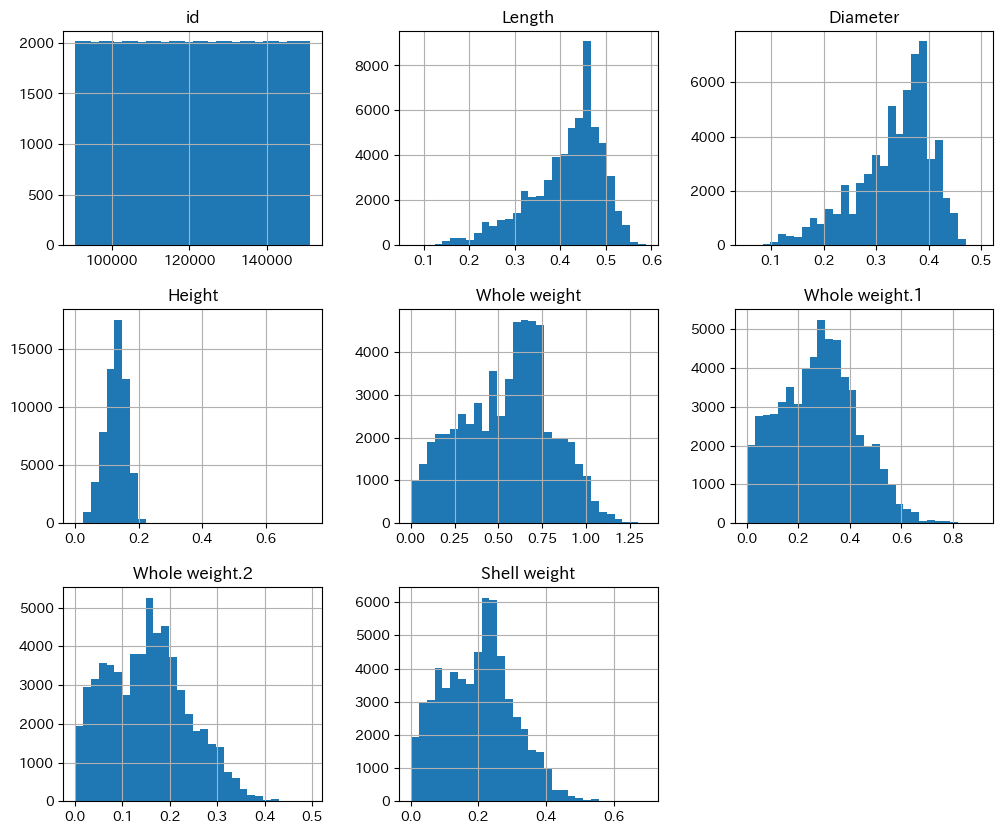

In [733]:
df_test.hist(bins=30, figsize=(12, 10))
plt.show()


?14が欠けているのはなぜだろう。<br>
稚貝は年輪が少なく、雄雌はだいたい同じくらいか。

In [734]:
column_names = df_train.columns.tolist()
column_names

['id',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings',
 'F',
 'I',
 'M']

In [735]:
'''
# 数値列のみを抽出
numerical_columns = [
 'id',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings',
 'F',
 'I',
 'M']

# カテゴリカルな列を抽出
categorical_column =  ['F', 'I', 'M']

# カテゴリカルな列のヒストグラムを描画する
plt.figure(figsize=(12, 10))
plt.subplot(3, 4, 1)
sns.countplot(data=df_train, x=categorical_column, color='skyblue')
plt.xlabel(categorical_column)
plt.ylabel('Count')

# 数値列のヒストグラムを描画する
for i, column in enumerate(numerical_columns, 2):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[column], bins=20, kde=True, color='skyblue')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
'''

"\n# 数値列のみを抽出\nnumerical_columns = [\n 'id',\n 'Length',\n 'Diameter',\n 'Height',\n 'Whole weight',\n 'Whole weight.1',\n 'Whole weight.2',\n 'Shell weight',\n 'Rings',\n 'F',\n 'I',\n 'M']\n\n# カテゴリカルな列を抽出\ncategorical_column =  ['F', 'I', 'M']\n\n# カテゴリカルな列のヒストグラムを描画する\nplt.figure(figsize=(12, 10))\nplt.subplot(3, 4, 1)\nsns.countplot(data=df_train, x=categorical_column, color='skyblue')\nplt.xlabel(categorical_column)\nplt.ylabel('Count')\n\n# 数値列のヒストグラムを描画する\nfor i, column in enumerate(numerical_columns, 2):\n    plt.subplot(3, 3, i)\n    sns.histplot(df_train[column], bins=20, kde=True, color='skyblue')\n    plt.xlabel(column)\n    plt.ylabel('Frequency')\n\nplt.tight_layout()\nplt.show()\n"

In [736]:
#sns.stripplot(x='Height', data=df_train)

In [737]:
#df_train.query('Height >= 0.4')

Heightが大きいというのは、縦長に育った可能性がある。<br>
外れ値と見なさずそのまま残す。

C:\Users\whand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
C:\Users\whand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


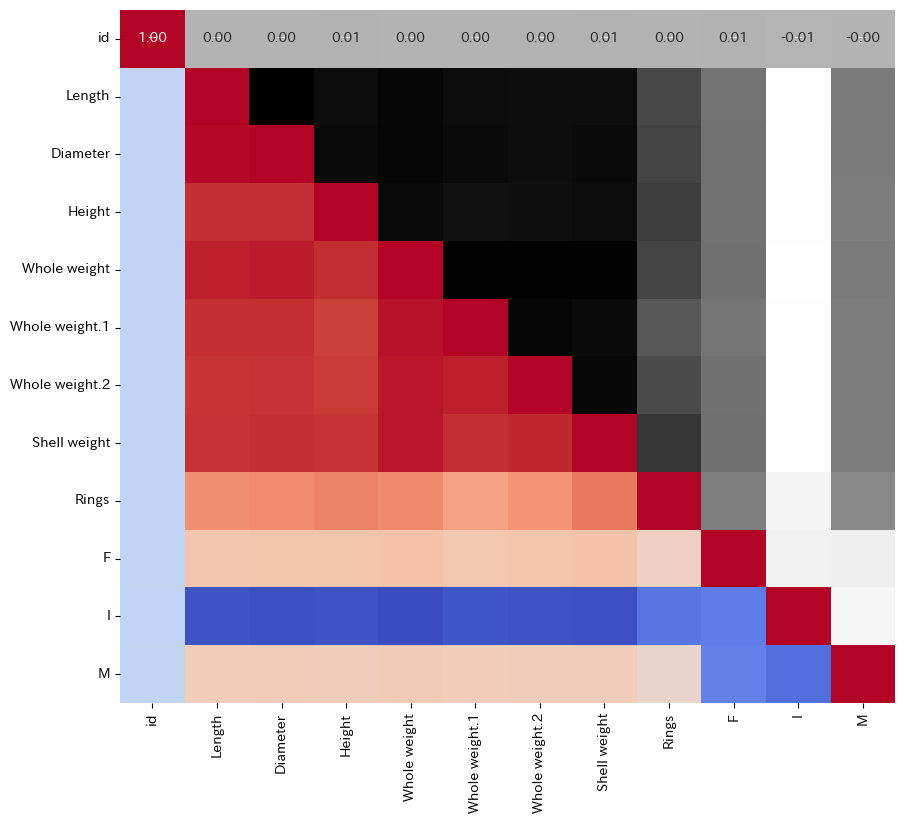

In [738]:

soukan = df_train.corr()

n = soukan.shape[0]
mask = np.triu(np.ones((n, n), dtype=bool), k=1)

plt.figure(figsize=(10, 9))
sns.heatmap(soukan, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar=False)
sns.heatmap(soukan, annot=True, cmap='Greys', fmt=".2f", mask=~mask, cbar=False)
plt.savefig('heatmap_2comb.png', bbox_inches='tight')
plt.show()


Diameter、Lengthの相関係数は正の相関が強い。<br>
⇒両方ともその他との相関係数は高めで似通っている。lengthのみ使用していく。<br>
Whole weightとwholeweight.1、.2も正の相関が強く出ている。<br>
.1、.2、shellweightを足し合わせたものがwholeweigtのような感じがする。<br>
⇒wholeerightを除去してみる。


In [739]:
#多重共線性がどうこうなっているかと思ったが、以下ドロップするとScoreが下がったためなかったことにする。
'''
df_train = df_train.drop(columns=['Diameter', 'Whole weight'])
'''


"\ndf_train = df_train.drop(columns=['Diameter', 'Whole weight'])\n"

---

### 可視化

In [740]:

import ydata_profiling
df_train.profile_report()


ModuleNotFoundError: No module named 'ipywidgets'

---

### 予測モデルの学習

In [741]:
#説明変数X（Rings以外)と目的変数(Rings)に分ける。
X = df_train.drop(columns=['id', 'Rings']).to_numpy()
y = df_train['Rings'].to_numpy()

In [742]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

def objective(trial, X_train, y_train, X_test, y_test):
    # LGBMRegressor に最適化するパラメータを定義する
    param = {
        "objective": "regression",
        "metric": "None",  # デフォルトのメトリクスを無効にする
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600), #決定木の数を指定
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    # 提案されたパラメータを使用して LGBMRegressor のインスタンスを作成します
    lgbm_regressor = LGBMRegressor(**param)
    
    # トレーニングデータにリグレッサーを当てはめる
    lgbm_regressor.fit(X_train, y_train)

    # テストデータから予測する
    y_pred = lgbm_regressor.predict(X_test)

    # RMSLE を計算する
    score = np.sqrt(mean_squared_log_error(y_test, y_pred))
    
    return score  # RMSLE を最小化する

# データをトレーニング セットとテスト セットに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 必要に応じて test_size を調整します

# Optuna 最適化用のサンプラーをセットアップする
sampler = optuna.samplers.TPESampler(seed=42)  # 最適化のためにツリー構造の Parzen Estimator サンプラーを使用する

# Optuna 最適化のためのスタディ オブジェクトを作成する
study = optuna.create_study(direction="minimize", sampler=sampler)  # RMSLE を最小化する

# 最適化プロセスを実行する
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# 最適化後に最適なパラメータを取得する
best_params = study.best_params

print('='*50)
print(best_params)

[I 2024-04-27 22:40:02,248] A new study created in memory with name: no-name-f867885e-4c3d-42b7-bdc6-d7e986167587
[I 2024-04-27 22:40:03,262] Trial 0 finished with value: 0.14960048739852755 and parameters: {'learning_rate': 0.0249816047538945, 'n_estimators': 591, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 45}. Best is trial 0 with value: 0.14960048739852755.
[I 2024-04-27 22:40:04,097] Trial 1 finished with value: 0.14922399545456647 and parameters: {'learning_rate': 0.034044600469728355, 'n_estimators': 542, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 13, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 17}. Best is trial 1 with value: 0.14922399545456647.
[I 2024-04-27 22:40:04,942] Trial 2 finished with value: 0.14999885378101685 and parameters: {'learning_rate': 0.

{'learning_rate': 0.04905465286224006, 'n_estimators': 595, 'lambda_l1': 0.005630795819099714, 'lambda_l2': 0.056504100870946435, 'max_depth': 10, 'colsample_bytree': 0.5762265539561713, 'subsample': 0.8111745024809555, 'min_child_samples': 42}


In [743]:
best_params

{'learning_rate': 0.04905465286224006,
 'n_estimators': 595,
 'lambda_l1': 0.005630795819099714,
 'lambda_l2': 0.056504100870946435,
 'max_depth': 10,
 'colsample_bytree': 0.5762265539561713,
 'subsample': 0.8111745024809555,
 'min_child_samples': 42}

目につくmax_depthが大きくなった時よい結果となる気がする。<br>
⇒調べた：大きくなったとか以前に"max_depth" は、決定木の深さを制御するパラメータだから単純に複雑なモデルになったというだけの話だった。

In [744]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

LGBMRegressor(colsample_bytree=0.5762265539561713,
              lambda_l1=0.005630795819099714, lambda_l2=0.056504100870946435,
              learning_rate=0.04905465286224006, max_depth=10,
              min_child_samples=42, n_estimators=595,
              subsample=0.8111745024809555)

---

# 評価

In [745]:
model.score(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.7149188783666007

In [746]:
model.score(X_test, y_test)

[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.6713143336561522

In [747]:
from sklearn.metrics import mean_squared_error

# 最適なハイパーパラメータを使用してモデルをトレーニングする
best_lgbm_regressor = LGBMRegressor(**study.best_params)
best_lgbm_regressor.fit(X_train, y_train)

# テストデータでの予測を行う
y_pred_test = best_lgbm_regressor.predict(X_test)

# RMSEを計算する
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE:", rmse)


[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

決定係数の当てはまりの良さを<br><br>
0.8<  精度良い<br>
0.5<= 精度普通 <=0.8<br>
0.5>  精度悪い<br><br>
を参考に**0.8**を目指してみる。<br>

基準モデル0.7130482126220046から開始

---

In [748]:
'''learn_log = pd.read_csv('learn_log1.csv')
learn_log.tail()'''

"learn_log = pd.read_csv('learn_log1.csv')\nlearn_log.tail()"

---

In [749]:
features = df_test.drop(['id'], axis=1)
predictions = model.predict(features)

[LightGBM] [Warning] lambda_l1 is set=0.005630795819099714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005630795819099714
[LightGBM] [Warning] lambda_l2 is set=0.056504100870946435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056504100870946435
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [750]:
submission = pd.DataFrame()
submission['id']=df_test['id']
submission['Rings']=predictions

In [751]:
submission

,id,Rings
0,90615,9.740032
1,90616,9.689813
2,90617,9.953132
3,90618,10.606655
4,90619,7.597403
...,...,...
60406,151021,6.331993
60407,151022,9.403474
60408,151023,12.818620
60409,151024,13.570355


In [752]:
submission.to_csv('submission.csv', index=False)

In [753]:
'''
import graphviz
from lightgbm import plot_tree

# ツリーのインデックスを指定
tree_index = 0

# ツリーを可視化
dot_data = plot_tree(model, tree_index=tree_index)
graph = graphviz.Source(dot_data)
graph.render(filename='tree_visualization', format='png', cleanup=True, directory='./')  
'''

"\nimport graphviz\nfrom lightgbm import plot_tree\n\n# ツリーのインデックスを指定\ntree_index = 0\n\n# ツリーを可視化\ndot_data = plot_tree(model, tree_index=tree_index)\ngraph = graphviz.Source(dot_data)\ngraph.render(filename='tree_visualization', format='png', cleanup=True, directory='./')  \n"

4/13<br>
稼働中のkaggleプレイグラウンド:アワビの年齢当て挑戦開始。<br>
やったことのある重回帰分析にてとりあえず提出してみる。<br>
マイナスが含まれるため平均二乗対数誤差が使用できませんとエラーがでる。<br>
そもそも平均二乗対数誤差て。重回帰じゃないということか？<br>
↓<br>
4/15<br>
予測モデルの学習を手筋に倣って初手LGBM。FirstEntry成功。872/1450位<br>
↓<br>
4/20<br>
Code参考にしてパラメータ写経。602/1845位